# BT5240: Computational Systems Biology
## Course Project: Analysis of metabolic state shifts in acute myeloid leukemia through transcriptome based flux constraints in Human Recon 2 metabolic model
Krithikaa Senthilkumar BE20B020 \\
Prahalaad Varahaswami BE20B024

In [1]:
# To access files deposited in a google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

### Loading and Preprocessing the required datasets

In [3]:
######################
# Load file with healthy bone marrow expression levels and calculate TPM with given FPKM values
######################

with open('/content/drive/My Drive/csb project/healthy_bonemarrow.txt', 'r') as file:
  healthyTissuedf = pd.read_csv(file,sep='\t')

healthyTissuedf['tpm'] = [i*10**6/sum(healthyTissuedf['FPKM(bonemarrow_5a.V230)']) for i in healthyTissuedf['FPKM(bonemarrow_5a.V230)']] # Calculating tpm
healthyTissuedf=healthyTissuedf.iloc[:,[0,89,90,91,92,96]]
healthyTissuedf.rename(columns={'ensembl gene ID': 'gene_id'}, inplace=True)
print(healthyTissuedf.shape)
healthyTissuedf.head()

(20050, 6)


<ipython-input-3-788ea96d95b3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthyTissuedf.rename(columns={'ensembl gene ID': 'gene_id'}, inplace=True)


,gene_id,FPKM(bonemarrow_5a.V230),FPKM(bonemarrow_6a.V248),FPKM(bonemarrow_6b.V249),FPKM(bonemarrow_6c.V250),tpm
0,ENSG00000127720,2.63774,1.26833,3.37925,1.60165,5.634862
1,ENSG00000256574,0.12029,0.00000,0.09225,0.05273,0.256969
2,ENSG00000109819,0.02228,0.00000,0.01820,0.00821,0.047596
3,ENSG00000161057,47.73160,74.49120,60.45910,93.84090,101.966448
4,ENSG00000237787,0.00000,0.00000,0.00000,0.00000,0.000000


In [4]:
######################
# Load file with diseased (AML) bone marrow sample with gene expression values
######################

with open('/content/drive/My Drive/csb project/AML_14ykid.tsv', 'r') as file:
  amldf=pd.read_csv(file,sep='\t',header=1)

amldf=amldf.iloc[4:,[0,1,6]] # Keep only required columns and remove the header rows
amldf['gene_id'] = [id.split(".")[0].strip() for id in amldf['gene_id']] # Replace the decimal point in the ensembl ID and all characters to its right with an empty string
amldf.rename(columns={'tpm_unstranded': 'tpm'}, inplace=True)

print(amldf.shape)
amldf.head()

(60660, 3)


,gene_id,gene_name,tpm
4,ENSG00000000003,TSPAN6,0.0679
5,ENSG00000000005,TNMD,0.0000
6,ENSG00000000419,DPM1,46.6657
7,ENSG00000000457,SCYL3,2.8172
8,ENSG00000000460,C1orf112,2.1911


In [5]:
######################
# Load file with the AML gene regulatory network for TF-target gene interaction data
######################
with open('/content/drive/My Drive/csb project/AML_grn.txt', 'r') as file:
  grndf=pd.read_csv(file ,sep='\t',header=0)

grndf = grndf[grndf['Confidence'] == 'High'] # retain high confidence interactions
print(grndf.shape)
grndf.head()

(45097, 6)


,TF,gene,bestMotif,NES,Genie3Weight,Confidence
0,A1CF,GNAT1,hdpi__ACF,3.45,0.007303,High
1,A1CF,RPL23AP87,hdpi__ACF,3.45,0.008207,High
2,AHCTF1,AHCTF1,cisbp__M0131,3.03,NaN,High
3,AHCTF1,AP1G1,cisbp__M0131,3.03,0.009322,High
4,AHCTF1,DYRK1A,cisbp__M0131,3.03,0.014870,High


In [6]:
######################
# Load file with the gene (and TF) list from the gene regulatory network
######################
with open('/content/drive/My Drive/csb project/grn_ensembl.csv', 'r') as file:
  grn_gene_list = pd.read_csv(file)

grn_gene_list.rename(columns={'initial_alias': 'gene_name','converted_alias':'gene_id'}, inplace=True)
grn_gene_list=grn_gene_list.iloc[:,[0,1,3]]
grn_gene_list.drop_duplicates(subset=['gene_name'],inplace=True)
grn_gene_list.reset_index(drop=True,inplace=True)

print(grn_gene_list.shape)
grn_gene_list.head()

(15592, 3)


,gene_name,gene_id,description
0,ZNF518B,ENSG00000178163,zinc finger protein 518B [Source:HGNC Symbol;A...
1,PLEKHH3,ENSG00000068137,"pleckstrin homology, MyTH4 and FERM domain con..."
2,WNT9B,ENSG00000158955,Wnt family member 9B [Source:HGNC Symbol;Acc:H...
3,TFAP4,ENSG00000090447,transcription factor AP-4 [Source:HGNC Symbol;...
4,YWHAEP1,ENSG00000232727,tyrosine 3-monooxygenase/tryptophan 5-monooxyg...


In [7]:
######################
# Load file with the gene list from the metabolic constraint based model (Recon 2)
######################
with open('/content/drive/My Drive/csb project/CBMGenes.csv', 'r') as file:
  cbm_gene_list = pd.read_csv(file)

cbm_gene_list=cbm_gene_list.iloc[:,[0,1,2,3]]
cbm_gene_list.rename(columns={'initial_alias':'entrez_no','converted_alias':'gene_id','name':'gene_name'}, inplace=True)
cbm_gene_list.drop_duplicates(subset=['gene_name'],inplace=True)
cbm_gene_list.reset_index(drop=True,inplace=True)
print(len(cbm_gene_list))
cbm_gene_list.head()

1653


,entrez_no,gene_id,gene_name,description
0,65985,ENSG00000081760,AACS,acetoacetyl-CoA synthetase [Source:HGNC Symbol...
1,8639,ENSG00000131471,AOC3,amine oxidase copper containing 3 [Source:HGNC...
2,39,ENSG00000120437,ACAT2,acetyl-CoA acetyltransferase 2 [Source:HGNC Sy...
3,38,ENSG00000075239,ACAT1,acetyl-CoA acetyltransferase 1 [Source:HGNC Sy...
4,55902,ENSG00000131069,ACSS2,acyl-CoA synthetase short chain family member ...


## Functions to obtain individual regulatory interactions and obtain respective expression values

### get_regulatory_genes(cbm_genes, grn_genes, grndf)
**Input:** \\
cbm_genes (dataframe containing genes from metabolic model along with ensembl IDs) \\
grn_genes (dataframe containing genes from gene-TF network along with ensembl IDs) \\
grndf (dataframe containing edge list of gene-TF interactions) \\
**Output:** \\
reg_genes_dict (Dictionary containing target genes as keys and corresponding regulatory genes as values)

In [8]:
def get_regulatory_genes(cbm_genes,grn_genes,grndf):
  reg_genes_dict={}
  for gene in cbm_genes['gene_id']:
    if gene in grn_genes['gene_id'].values:
      gene_name=grn_genes[grn_genes['gene_id']==gene]['gene_name'].values[0]
      if len(grndf[grndf['gene'] == gene_name]['TF'].values) > 0:
        reg_genes_dict[gene_name] = grndf[grndf['gene'] == gene_name]['TF'].values
  return reg_genes_dict

In [9]:
regulatory_genes=get_regulatory_genes(cbm_gene_list,grn_gene_list,grndf)
len(regulatory_genes)

1166

## get_target_gene_expression(reg_genes_dict, grn_genes, expdf)
**Input:** \\
reg_genes_dict (Dictionary containing target genes as keys and corresponding regulatory genes as values) \\
grn_genes (dataframe containing genes from gene-TF network along with ensembl IDs) \\
expdf (Dataframe containing gene names and corresponding expession values for a given sample) \\
**Output:** \\
target_exp (Dictionary of expression values of gene keys in reg_genes_dict.keys())


In [10]:
def get_target_gene_expression(reg_genes_dict,grn_genes,expdf):
  target_exp = {}
  for gene in reg_genes_dict.keys():
    arr=expdf[expdf['gene_id'] == grn_genes[grn_genes['gene_name'] == gene]['gene_id'].values[0]]['tpm'].values
    if len(arr)!=0:
      target_exp[gene] = arr[0]
    else:
      target_exp[gene] = 0
  return target_exp

In [11]:
target_exp_hel = get_target_gene_expression(regulatory_genes, grn_gene_list, healthyTissuedf)
len(target_exp_hel) # healthy target gene expessions

1166

In [12]:
target_exp_dis = get_target_gene_expression(regulatory_genes, grn_gene_list, amldf)
len(target_exp_dis) # diseased target gene expessions

1166

## get_regulatory_expression_sum(reg_genes_dict,expdf)

**Input:** \\
reg_genes_dict (Dictionary containing target genes as keys and corresponding regulatory genes as values) \\
expdf (Dataframe containing gene names and corresponding expession values for a given sample) \\
**Output:** \\
sum_reg_exp (Dictionary of sum of expression values of regulatory genes in reg_genes_dict.values(), keys are reg_genes_dict.keys())


In [13]:
def get_regulatory_expression_sum(reg_genes_dict,expdf):
  sum_reg_exp={}
  for gene in reg_genes_dict:
    val = 0
    for reg_gene in regulatory_genes[gene]:
      # Check if there are matching rows
      reg_gene_id = grn_gene_list[grn_gene_list['gene_name'] == reg_gene].iloc[0]['gene_id']
      matching_rows = expdf[expdf['gene_id'] == reg_gene_id]
      if not matching_rows.empty:
        val += matching_rows['tpm'].values[0]
    sum_reg_exp[gene]=val
  return sum_reg_exp

In [14]:
sum_reg_exp_hel=get_regulatory_expression_sum(regulatory_genes,healthyTissuedf)
len(sum_reg_exp_hel) # sum eg exp for healthy tissue

1166

In [15]:
sum_reg_exp_dis=get_regulatory_expression_sum(regulatory_genes,amldf)
len(sum_reg_exp_dis) # sum eg exp for diseased tissue

1166

## model_set_upper_bounds(model, reg_dict, sum_reg_exp, target_exp)

**Input:** \\
reg_dict (Dictionary containing target genes as keys and corresponding regulatory genes as values) \\
sum_reg_exp (Dictionary of sum of expression values of regulatory genes in reg_genes_dict.values(), keys are reg_genes_dict.keys()) \\
target_exp (Dictionary of expression values of gene keys in reg_genes_dict.keys()) \\
effect_factor (Constant to multiply to the sum of regulatory genes) \\
**Output:** \\
upper_bounds (list of entrez_id - upper flux bound pairs)




In [16]:
def model_set_upper_bounds(cbm_gene_list, target_exp, sum_reg_exp, effect_factor):
  upper_bounds=[]
  for gene in cbm_gene_list['gene_name'].values:
    if gene in list(target_exp.keys()):
      entrez_no = cbm_gene_list[cbm_gene_list['gene_name'] == gene].iloc[0]['entrez_no']
      #print(entrez_no)
      ub = target_exp[gene] + effect_factor*sum_reg_exp[gene]
      upper_bounds.append([entrez_no,ub])
  return upper_bounds

In [20]:
upper_bounds_hel = model_set_upper_bounds(cbm_gene_list, target_exp_hel, sum_reg_exp_hel, hel_a)
len(upper_bounds_hel)

1159

In [ ]:
upper_bounds_dis = model_set_upper_bounds(cbm_gene_list, target_exp_dis, sum_reg_exp_dis, dis_a)
len(upper_bounds_dis)

1159

In [ ]:
## Exporting array to csv to use in matlab
import csv
with open('upper_bounds_dis.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerows(upper_bounds_dis)

## Finding outer limit of effect of expression by plotting target gene exp v/s sum regulatoy gene expression and fitting a line

In [19]:
hel_a,_= np.polyfit(np.array(list(sum_reg_exp_hel.values())), np.array(list(target_exp_hel.values())), 1)
dis_a,_= np.polyfit(np.array(list(sum_reg_exp_dis.values())), np.array(list(target_exp_dis.values())), 1)
hel_a, dis_a

(0.03458555265538505, 0.04026054633842868)

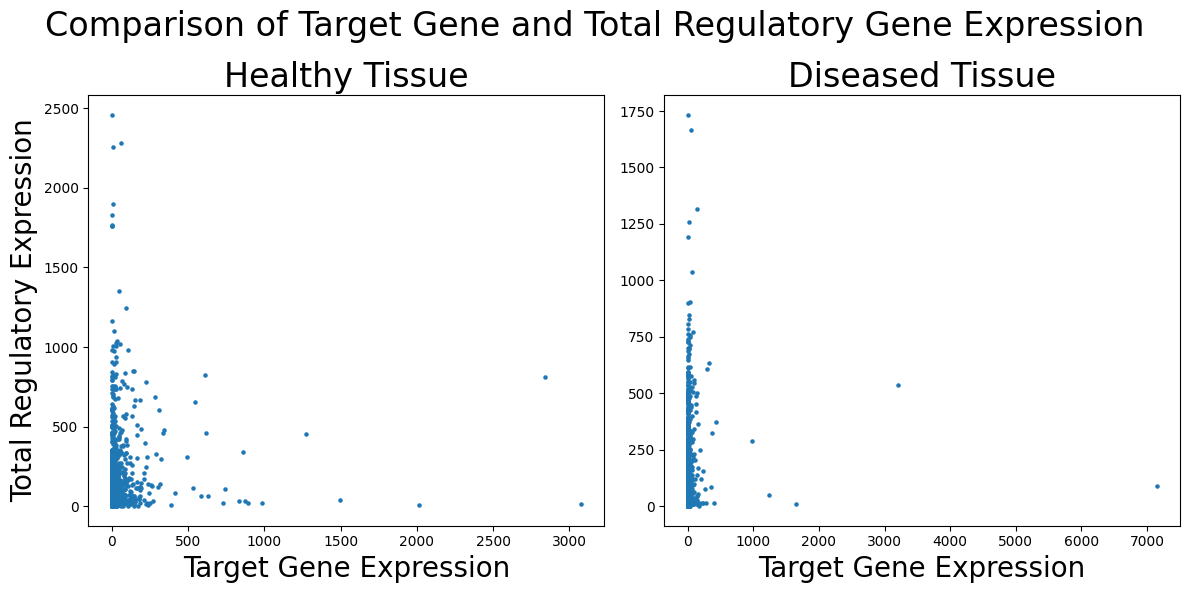

In [27]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for healthy tissue
sum_reg_exp_array_hel = np.array(list(sum_reg_exp_hel.values()))
target_exp_array_hel = np.array(list(target_exp_hel.values()))
axs[0].scatter(target_exp_array_hel, sum_reg_exp_array_hel, s=5)
axs[0].set_xlabel('Target Gene Expression', fontsize=20)  # Increase font size of x-axis label
axs[0].set_ylabel('Total Regulatory Expression', fontsize=20)  # Increase font size of y-axis label
axs[0].set_title('Healthy Tissue', fontsize=24)  # Set subplot title

# Plot for diseased tissue
sum_reg_exp_array_dis = np.array(list(sum_reg_exp_dis.values()))
target_exp_array_dis = np.array(list(target_exp_dis.values()))
axs[1].scatter(target_exp_array_dis, sum_reg_exp_array_dis, s=5)
axs[1].set_xlabel('Target Gene Expression', fontsize=20)  # Increase font size of x-axis label
axs[1].set_ylabel('', fontsize=20)  # Increase font size of y-axis label
axs[1].set_title('Diseased Tissue', fontsize=24)  # Set subplot title

# Set common title for the entire figure
fig.suptitle('Comparison of Target Gene and Total Regulatory Gene Expression', fontsize=24)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


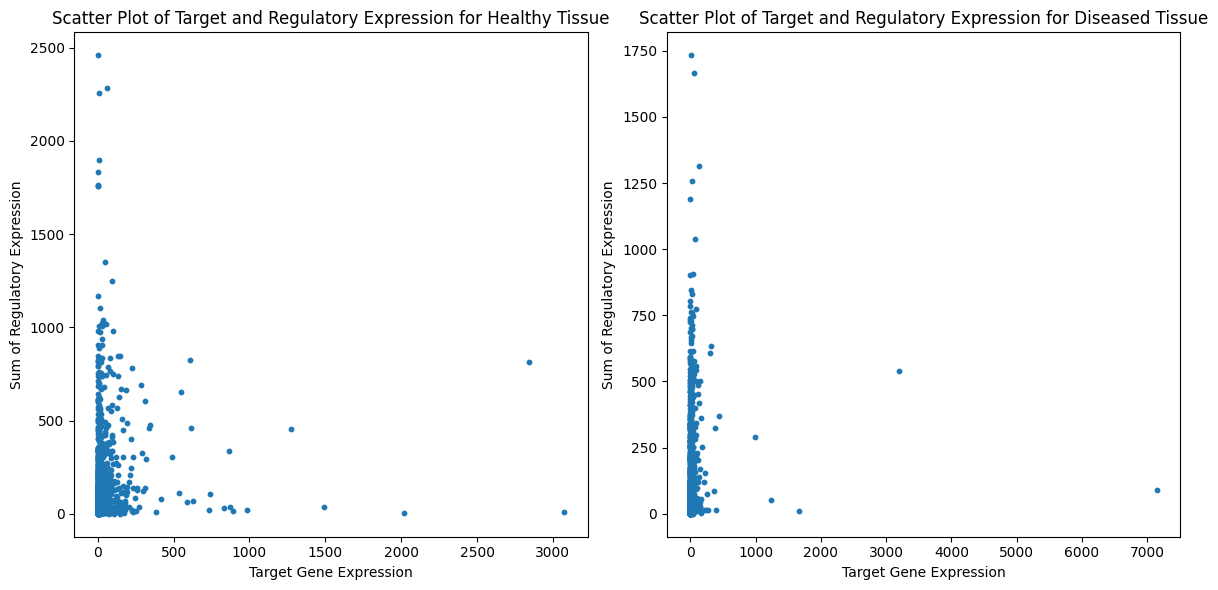

In [ ]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for healthy tissue
sum_reg_exp_array_hel = np.array(list(sum_reg_exp_hel.values()))
target_exp_array_hel = np.array(list(target_exp_hel.values()))
axs[0].scatter(target_exp_array_hel, sum_reg_exp_array_hel, s=10)
axs[0].set_xlabel('Target Gene Expression')
axs[0].set_ylabel('Sum of Regulatory Expression')
axs[0].set_title('Scatter Plot of Target and Regulatory Expression for Healthy Tissue')

# Plot for diseased tissue
sum_reg_exp_array_dis = np.array(list(sum_reg_exp_dis.values()))
target_exp_array_dis = np.array(list(target_exp_dis.values()))
axs[1].scatter(target_exp_array_dis, sum_reg_exp_array_dis, s=10)
axs[1].set_xlabel('Target Gene Expression')
axs[1].set_ylabel('Sum of Regulatory Expression')
axs[1].set_title('Scatter Plot of Target and Regulatory Expression for Diseased Tissue')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


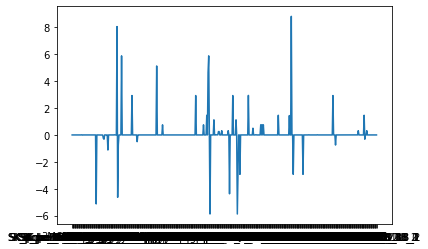

In [ ]:
plt.plot(solution.fluxes, scalex=[i for i in range(len(solution.fluxes))])

# DUSTBIN

In [ ]:
reg_solution = model.optimize()

In [ ]:
flux = pd.DataFrame(solution.fluxes)
flux

,fluxes
SK_pchol_hs_18_1_18_1_c,0.0
SK_pchol_hs_18_1_18_2_c,0.0
SK_pchol_hs_18_2_16_0_c,0.0
SK_pchol_hs_18_2_18_1_c,0.0
SK_pe_hs_16_0_16_0_c,0.0
...,...
CEPTC_18_2_16_0,0.0
CEPTC_18_2_18_1,0.0
CEPTE_16_0_18_1,0.0
CEPTE_16_0_18_2,0.0


In [ ]:
flux['regulation'] = reg_solution.fluxes
flux['fluxes'].value_counts

<bound method IndexOpsMixin.value_counts of SK_pchol_hs_18_1_18_1_c    0.0
SK_pchol_hs_18_1_18_2_c    0.0
SK_pchol_hs_18_2_16_0_c    0.0
SK_pchol_hs_18_2_18_1_c    0.0
SK_pe_hs_16_0_16_0_c       0.0
                          ... 
CEPTC_18_2_16_0            0.0
CEPTC_18_2_18_1            0.0
CEPTE_16_0_18_1            0.0
CEPTE_16_0_18_2            0.0
CEPTE_18_1_18_1            0.0
Name: fluxes, Length: 469, dtype: float64>

In [ ]:
solution.fluxes, reg_solution.fluxes

(SK_pchol_hs_18_1_18_1_c    0.0
 SK_pchol_hs_18_1_18_2_c    0.0
 SK_pchol_hs_18_2_16_0_c    0.0
 SK_pchol_hs_18_2_18_1_c    0.0
 SK_pe_hs_16_0_16_0_c       0.0
                           ... 
 CEPTC_18_2_16_0            0.0
 CEPTC_18_2_18_1            0.0
 CEPTE_16_0_18_1            0.0
 CEPTE_16_0_18_2            0.0
 CEPTE_18_1_18_1            0.0
 Name: fluxes, Length: 469, dtype: float64,
 SK_pchol_hs_18_1_18_1_c    0.0
 SK_pchol_hs_18_1_18_2_c    0.0
 SK_pchol_hs_18_2_16_0_c    0.0
 SK_pchol_hs_18_2_18_1_c    0.0
 SK_pe_hs_16_0_16_0_c       0.0
                           ... 
 CEPTC_18_2_16_0            0.0
 CEPTC_18_2_18_1            0.0
 CEPTE_16_0_18_1            0.0
 CEPTE_16_0_18_2            0.0
 CEPTE_18_1_18_1            0.0
 Name: fluxes, Length: 469, dtype: float64)

In [ ]:
solution.fluxes - reg_solution.fluxes

SK_pchol_hs_18_1_18_1_c    0.0
SK_pchol_hs_18_1_18_2_c    0.0
SK_pchol_hs_18_2_16_0_c    0.0
SK_pchol_hs_18_2_18_1_c    0.0
SK_pe_hs_16_0_16_0_c       0.0
                          ... 
CEPTC_18_2_16_0            0.0
CEPTC_18_2_18_1            0.0
CEPTE_16_0_18_1            0.0
CEPTE_16_0_18_2            0.0
CEPTE_18_1_18_1            0.0
Name: fluxes, Length: 469, dtype: float64